In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


C:\Users\gurki\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# === 1. Загрузка и фильтрация данных (только 2019–2024) ===
df = pd.read_csv('project_RM.csv')  # путь к твоему файлу
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format="%d/%m/%y")
df.columns = ['TICKER', 'DATE', 'CLOSE']
df = df[df['DATE'] >= '2019-01-01']  # фильтрация по дате

In [3]:
# === 2. Подготовка таблицы цен ===
price_df = df.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index()
price_df = price_df.dropna(axis=1)

In [4]:
# === 3. Расчёт доходностей и ковариационной матрицы ===
returns = price_df.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

tickers = returns.columns.tolist()
mean_returns = mean_returns[tickers]
cov_matrix = cov_matrix.loc[tickers, tickers]
n = len(tickers)

In [5]:
# === 4. Функция для оптимизации волатильности ===
def negative_volatility(weights):
    return -np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [6]:
# === 5. Условия и начальное приближение ===
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(-3, 3)] * n
init_guess = np.ones(n) / n

In [7]:
# === 6. Оптимизация самого рискованного портфеля ===
opt_result = minimize(negative_volatility, init_guess, method='SLSQP',
                      bounds=bounds, constraints=constraints)
risky_weights = opt_result.x
risky_vol = -opt_result.fun
risky_return = np.dot(risky_weights, mean_returns.values)

In [8]:
# === 7. Построение границы наиболее рискованных портфелей ===
target_returns = np.linspace(mean_returns.min() * 10, mean_returns.max() * 1.5, 80)
risky_vols = []

for target in target_returns:
    constraints_ext = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns.values) - target}
    ]
    result = minimize(lambda w: -np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))),
                      init_guess, method='SLSQP', bounds=bounds, constraints=constraints_ext)
    risky_vols.append(-result.fun if result.success else np.nan)

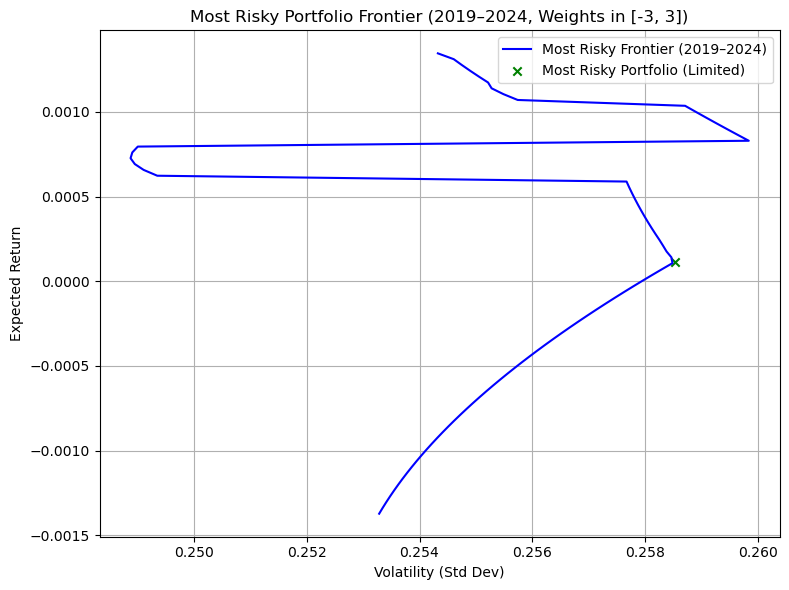

In [10]:
    # === 8. Построение графика ===
    plt.figure(figsize=(8, 6))
    plt.plot(risky_vols, target_returns, label='Most Risky Frontier (2019–2024)', color='blue')
    plt.scatter(risky_vol, risky_return, color='green', marker='x', label='Most Risky Portfolio (Limited)')
    plt.xlabel('Volatility (Std Dev)')
    plt.ylabel('Expected Return')
    plt.title('Most Risky Portfolio Frontier (2019–2024, Weights in [-3, 3])')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

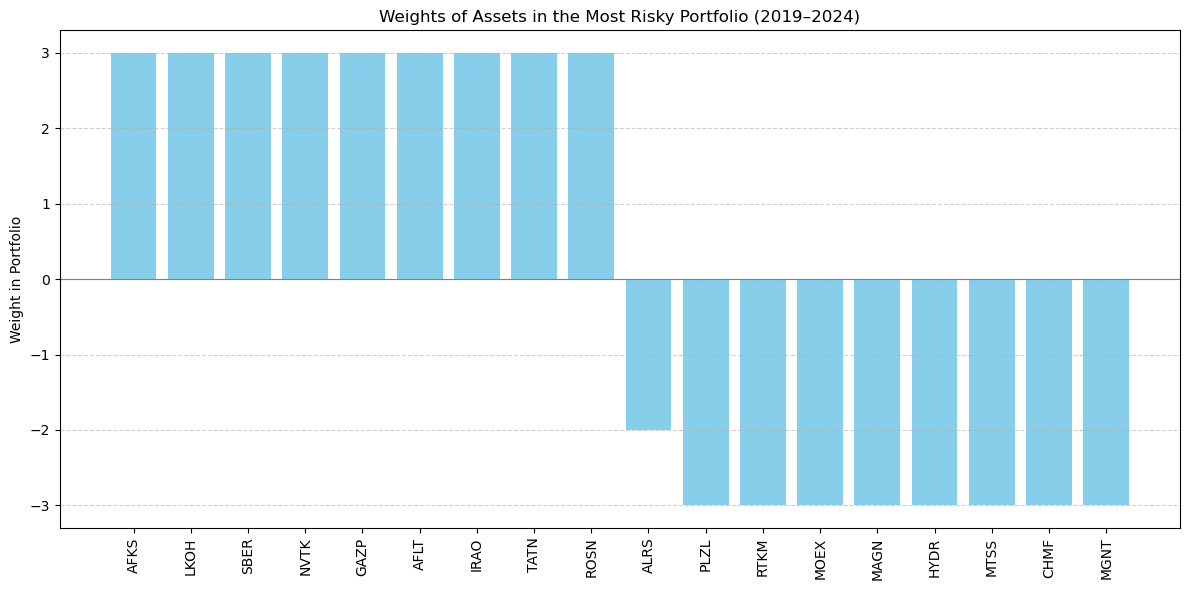

In [11]:
# Создание DataFrame с весами
weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight': risky_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(weights_df['Ticker'], weights_df['Weight'], color='skyblue')
plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel('Weight in Portfolio')
plt.title('Weights of Assets in the Most Risky Portfolio (2019–2024)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Для выявления структуры наиболее рискованного портфеля была решена задача максимизации волатильности при условии полной инвестированности капитала и допустимых весов в диапазоне [−3,3], что допускает ограниченные короткие продажи.

В качестве исторического окна были выбраны данные за период с 2019 по 2024 год. Это решение было обусловлено стремлением учесть актуальные рыночные условия, включая последствия пандемии COVID-19, геополитические изменения и санкционные ограничения. Такой подход позволяет избежать искажения оценок за счёт устаревших данных.

Построена граница наиболее рискованных портфелей при заданных уровнях ожидаемой доходности. Также определена структура портфеля, обладающего наивысшей волатильностью среди допустимых решений. Полученные результаты отражают поведение активов в условиях нестабильности и могут быть использованы для разработки стресс-сценариев в рамках риск-менеджмента.

Проведённый анализ показал, что при отсутствии жёстких ограничений на короткие продажи структура наиболее рискованного портфеля включает значительные лонг- и шорт-позиции.
Несмотря на высокую ожидаемую волатильность (около 25–26%), доходность такого портфеля остаётся нестабильной и чувствительной к выбору целевого уровня.
Это подчёркивает, что максимальный риск не гарантирует максимальную доходность, а потому такие портфели должны использоваться исключительно в стресс-анализе и стресс-тестировании, а не в практическом инвестировании.